# **Pre-processing & Feature Engineering**

**Author**: Grace Samuel  
**Project**: Biopharma Funding Analysis  
**Notebook Purpose**: This notebook performs data preprocessing, feature engineering, and unsupervised learning (PCA and K-Means) in preparation for supervised modeling to predict funding outcomes for biopharma companies.


## 1. Load Libraries


In [142]:
# File upload (Google Colab)
from google.colab import files

# Basic data handling
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Train-test split
from sklearn.model_selection import train_test_split

# Collinearity and statistical analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Unsupervised learning
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Supervised feature selection (planned)
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# System / warning handling
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)


## 2. Load Dataset


In [143]:
# Upload the CSV file from local machine (for Google Colab use)
uploaded = files.upload()

# Load the uploaded file into a pandas DataFrame
df = pd.read_csv(next(iter(uploaded)))

# Confirm that the dataset loaded successfully
print(f"Dataset loaded. Shape: {df.shape}")
df.head()


Saving preprocessing_dataset.csv to preprocessing_dataset (4).csv
Dataset loaded. Shape: (9591, 17)


,company,amount,round,completed,federal_fund_effective_rate,10yr_treasury_yield,lead_investor_this_round,lead_investor_co_type,stage_at_funding,primary_ta,indications,primary_tech,company_type,location,business_model,public_private,total_raised_all_rounds
0,Alba Therapeutics Corp.,30.0,Series A,8/23/2005,3.49,NaN,SV Health Investors LLP,Fin - VC / Private Equity,Phase III,Autoimmune,Gastrointestinal (GI) dysfunction,Small Molecule,Private,Maryland,Platform and Own Product Development,Private,30.0
1,Allozyne Inc. (MedImmune),3.5,Series A,12/6/2005,3.97,4.49,NaN,NaN,Phase III,Autoimmune,Rheumatoid Arthritis; Psoriasis; Crohn’s Disea...,Antibody,Private,Washington,Late Stage Dev and Commercialization,Private,34.0
2,Allozyne Inc. (MedImmune),30.0,Series B,10/26/2007,4.80,4.41,MPM BioImpact (aka MPM Capital),Fin - VC / Private Equity,Phase III,Autoimmune,Rheumatoid Arthritis; Psoriasis; Crohn’s Disea...,Antibody,Private,Washington,Late Stage Dev and Commercialization,Private,34.0
3,Anthera Pharmaceuticals Inc.,17.1,Common,3/2/2010,0.14,3.62,NaN,NaN,Phase II,Autoimmune,Pancreatic insufficiency,Small Molecule,Public Small,California,Platform and Own Product Development,Public,336.0
4,Senesco Technologies Inc.,10.3,Convertible Notes,3/29/2010,0.16,3.88,NaN,NaN,Preclinical / IND,Autoimmune,Multiple myeloma (MM),Antibody,Public Small,Massachusetts,Platform and Own Product Development,Public,12.0


## 3. Additional Cleaning After EDA


In [144]:
# Drop columns with high missingness and/or high collinearity
columns_to_drop = [
    'lead_investor_this_round',
    'lead_investor_co_type',
    '10yr_treasury_yield',
    'total_raised_all_rounds'
]
df.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {df.shape[1]}")

# Drop unique identifier column
df.drop(columns=['company'], inplace=True)
print("Dropped unique identifier column: 'company'")

# Remove rows for 'Public Large' companies (to focus on smaller companies)
original_row_count = len(df)
df = df[df['company_type'] != 'Public Large']
print(f"Removed 'Public Large' rows: {original_row_count - len(df)} rows removed")
print("Remaining company types:\n", df['company_type'].value_counts())

# Convert 'completed' column to datetime and extract year
df['completed'] = pd.to_datetime(df['completed'], errors='coerce')
df['completed_year'] = df['completed'].dt.year
df.drop(columns=['completed'], inplace=True)
print("Converted 'completed' to year and dropped original column")
print("Sample of 'completed_year':", df['completed_year'].dropna().unique()[:5])


Dropped columns: ['lead_investor_this_round', 'lead_investor_co_type', '10yr_treasury_yield', 'total_raised_all_rounds']
Remaining columns: 13
Dropped unique identifier column: 'company'
Removed 'Public Large' rows: 205 rows removed
Remaining company types:
 company_type
Public Small     5241
Private          2972
Public Medium    1173
Name: count, dtype: int64
Converted 'completed' to year and dropped original column
Sample of 'completed_year': [2005. 2007. 2010. 2011. 2012.]


## 4. Train-Test Split

Custom Function & Split Ratio Calculation

In [148]:
# Custom helper function: calculate ideal split ratio based on number of predictors
def calc_split_ratio(df, p=None):
    """
    Calculate recommended test set proportion based on number of predictors.
    Formula: test_N = (1 / sqrt(p)) * N
    """
    if p is None:
        p = df.shape[1] - 1  # Assume last column is target if not specified
    test_N = (1 / np.sqrt(p)) * len(df)
    return test_N / len(df)  # Return test proportion

# Calculate ideal test set proportion
p = df.shape[1] - 1
test_prop = calc_split_ratio(df, p)
train_prop = 1 - test_prop

print(f"Split proportions — Train: {train_prop:.2f}, Test: {test_prop:.2f}")


Split proportions — Train: 0.70, Test: 0.30


Train-Test Split

In [146]:
# Define features and target
X = df.drop(columns=['amount'])
y = df['amount']

# Train-test split using calculated test proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_prop, random_state=1)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")



Train size: 6556, Test size: 2830


## 5. Encode Categorical Variables


In [150]:
# Custom function: collapse_categories
def collapse_categories(series, top_n, other_name="Other"):
    """
    Keeps only the top N most frequent categories in a series and replaces others with 'Other'.
    """
    top_categories = series.value_counts().nlargest(top_n).index
    return series.apply(lambda x: x if x in top_categories else other_name)

# Custom function: count_encode
def count_encode(train_col, test_col):
    """
    Replaces categorical values with their frequency counts from the training data.
    """
    counts = train_col.value_counts()
    train_encoded = train_col.map(counts)
    test_encoded = test_col.map(counts).fillna(0)
    return train_encoded, test_encoded

# Main encoding function
def encode_data(train_df, test_df):
    """
    Encodes categorical variables using a mix of category collapsing, count encoding, and binary mapping.
    Returns transformed training and test sets.
    """
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()

    # Collapse and encode stage_at_funding
    train_encoded['stage_at_funding'] = collapse_categories(train_encoded['stage_at_funding'], 6)
    test_encoded['stage_at_funding'] = collapse_categories(test_encoded['stage_at_funding'], 6)
    train_encoded['stage_at_funding'], test_encoded['stage_at_funding'] = count_encode(
        train_encoded['stage_at_funding'], test_encoded['stage_at_funding']
    )

    # Clean and encode primary_ta
    ta_other = ['Other', 'Not Applicable', 'Unknown']
    train_encoded['primary_ta'] = train_encoded['primary_ta'].replace(ta_other, 'TA Other')
    test_encoded['primary_ta'] = test_encoded['primary_ta'].replace(ta_other, 'TA Other')
    train_encoded['primary_ta'], test_encoded['primary_ta'] = count_encode(
        train_encoded['primary_ta'], test_encoded['primary_ta']
    )

    # Collapse and encode indications
    train_encoded['indications'] = collapse_categories(train_encoded['indications'], 10)
    test_encoded['indications'] = collapse_categories(test_encoded['indications'], 10)
    train_encoded['indications'], test_encoded['indications'] = count_encode(
        train_encoded['indications'], test_encoded['indications']
    )

    # Collapse and encode primary_tech
    train_encoded['primary_tech'] = collapse_categories(train_encoded['primary_tech'], 19)
    test_encoded['primary_tech'] = collapse_categories(test_encoded['primary_tech'], 19)
    train_encoded['primary_tech'], test_encoded['primary_tech'] = count_encode(
        train_encoded['primary_tech'], test_encoded['primary_tech']
    )

    # Simplify and encode location
    top_states = ['California', 'Massachusetts', 'New Jersey', 'New York', 'Pennsylvania']
    train_encoded['location'] = train_encoded['location'].apply(lambda x: x if x in top_states else 'Other')
    test_encoded['location'] = test_encoded['location'].apply(lambda x: x if x in top_states else 'Other')
    train_encoded['location'], test_encoded['location'] = count_encode(
        train_encoded['location'], test_encoded['location']
    )

    # Direct count encoding for selected variables
    count_vars = ['round', 'company_type', 'business_model']
    for col in count_vars:
        train_encoded[col], test_encoded[col] = count_encode(train_encoded[col], test_encoded[col])

    # Binary encode public/private column
    public_map = {'Public': 1, 'Private': 0}
    train_encoded['public_private'] = train_encoded['public_private'].map(public_map)
    test_encoded['public_private'] = test_encoded['public_private'].map(public_map)

    return train_encoded, test_encoded

# Apply encoding to training and test sets
X_train_encoded, X_test_encoded = encode_data(X_train, X_test)
print("Encoding completed. Encoded training shape:", X_train_encoded.shape)



Encoding completed. Encoded training shape: (6556, 11)


## 6. Impute Missing Values for X_train and X_test


In [151]:
# Check for missing values in encoded features
print("Missing values per column (train):")
display(X_train_encoded.isna().sum()[X_train_encoded.isna().sum() > 0])

print("Missing values per column (test):")
display(X_test_encoded.isna().sum()[X_test_encoded.isna().sum() > 0])


Missing values per column (train):


,0
federal_fund_effective_rate,51
completed_year,51


Missing values per column (test):


,0
federal_fund_effective_rate,19
completed_year,19


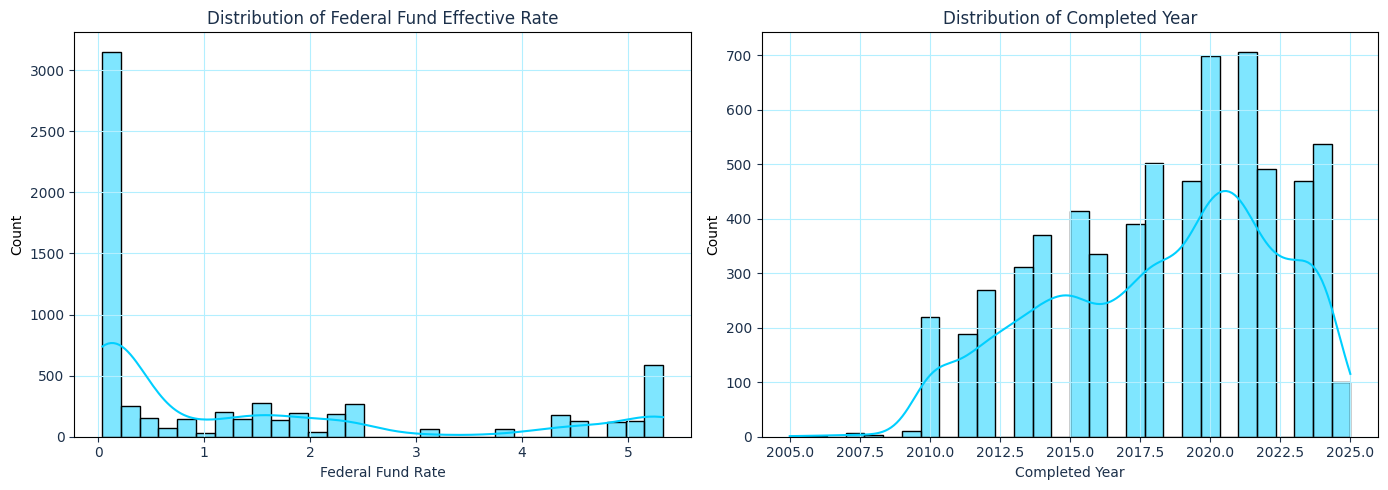

In [154]:
# Visualize distributions to inform imputation strategy

# Accessible color palette
palette = {
    "white": "#FFFFFF",
    "light": "#B3EFFF",
    "bright": "#00CFFF",
    "medium": "#046B99",
    "dark": "#1C304A",
    "black": "#000000"
}

# Visualize distributions of variables with missing values
fig, axs = plt.subplots(1, 2, figsize=(14, 5), facecolor=palette["white"])

# Plot: Federal Fund Effective Rate
sns.histplot(
    X_train_encoded['federal_fund_effective_rate'],
    kde=True,
    color=palette["bright"],
    ax=axs[0],
    bins=30
)
axs[0].set_title('Distribution of Federal Fund Effective Rate', color=palette["dark"])
axs[0].set_xlabel('Federal Fund Rate', color=palette["dark"])
axs[0].set_ylabel('Count')
axs[0].tick_params(colors=palette["dark"])
axs[0].grid(True, color=palette["light"])

# Plot: Completed Year
sns.histplot(
    X_train_encoded['completed_year'],
    kde=True,
    color=palette["bright"],
    ax=axs[1],
    bins=30
)
axs[1].set_title('Distribution of Completed Year', color=palette["dark"])
axs[1].set_xlabel('Completed Year', color=palette["dark"])
axs[1].set_ylabel('Count')
axs[1].tick_params(colors=palette["dark"])
axs[1].grid(True, color=palette["light"])

plt.tight_layout()
plt.show()



In [156]:
# Define columns to impute based on prior missing value check
columns_to_impute = ['federal_fund_effective_rate', 'completed_year']

# Instantiate median imputer (based on observed skew in distributions)
imputer = SimpleImputer(strategy='median')

# Fit on training data and transform both train and test sets
X_train_encoded[columns_to_impute] = imputer.fit_transform(X_train_encoded[columns_to_impute])
X_test_encoded[columns_to_impute] = imputer.transform(X_test_encoded[columns_to_impute])

# Validate missing values have been resolved
missing_train = X_train_encoded[columns_to_impute].isna().sum().sum()
missing_test = X_test_encoded[columns_to_impute].isna().sum().sum()

print(f"Missing values after imputation — Train: {missing_train}, Test: {missing_test}")


Missing values after imputation — Train: 0, Test: 0


## 7. Impute Missing Values for y_train and y_test


In [158]:
# Check how many missing values exist in y_train and y_test
print("Missing values in y_train:", y_train.isna().sum())
print("Missing values in y_test:", y_test.isna().sum())

# Create masks for missing values
missing_train = y_train.isna()
missing_test = y_test.isna()

# Subsets of data with and without missing y values
X_train_imp = X_train_encoded[~missing_train]  # where y is not missing
y_train_imp = y_train[~missing_train]

X_train_missing = X_train_encoded[missing_train]  # where y is missing
X_test_missing = X_test_encoded[missing_test]

# Instantiate and train a Random Forest Regressor to predict missing y values
from sklearn.ensemble import RandomForestRegressor

rf_imputer = RandomForestRegressor(n_estimators=100, random_state=42)
rf_imputer.fit(X_train_imp, y_train_imp)

# Predict and fill in missing y_train values
y_train_imputed = y_train.copy()
y_train_imputed[missing_train] = rf_imputer.predict(X_train_missing)

# Predict and fill in missing y_test values
y_test_imputed = y_test.copy()
y_test_imputed[missing_test] = rf_imputer.predict(X_test_missing)

# Validate that missing values are resolved
print("Missing values after imputation:")
print("y_train:", y_train_imputed.isna().sum())
print("y_test:", y_test_imputed.isna().sum())


Missing values in y_train: 208
Missing values in y_test: 89
Missing values after imputation:
y_train: 0
y_test: 0


## 8. Perform Arithmetic Transformation on Target Variable (Log-Transform)


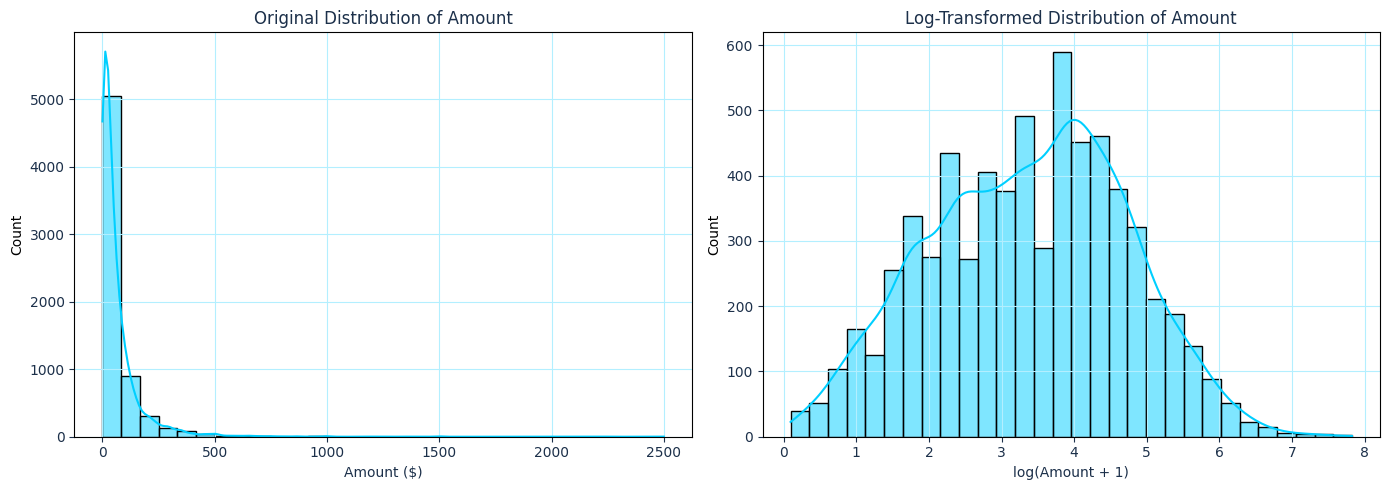

In [159]:
# Apply log transformation to reduce right skew in the target variable (amount)
y_train_log = np.log1p(y_train_imputed)
y_test_log = np.log1p(y_test_imputed)

# Accessible color palette
palette = {
    "white": "#FFFFFF",
    "light": "#B3EFFF",
    "bright": "#00CFFF",
    "medium": "#046B99",
    "dark": "#1C304A",
    "black": "#000000"
}

# Plot original vs log-transformed distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 5), facecolor=palette["white"])

# Original target variable distribution
sns.histplot(y_train_imputed, kde=True, color=palette["bright"], ax=axs[0], bins=30)
axs[0].set_title("Original Distribution of Amount", color=palette["dark"])
axs[0].set_xlabel("Amount ($)", color=palette["dark"])
axs[0].tick_params(colors=palette["dark"])
axs[0].grid(True, color=palette["light"])

# Log-transformed target variable distribution
sns.histplot(y_train_log, kde=True, color=palette["bright"], ax=axs[1], bins=30)
axs[1].set_title("Log-Transformed Distribution of Amount", color=palette["dark"])
axs[1].set_xlabel("log(Amount + 1)", color=palette["dark"])
axs[1].tick_params(colors=palette["dark"])
axs[1].grid(True, color=palette["light"])

plt.tight_layout()
plt.show()


## 9. Normalize, Center, and Scale Features


In [160]:
# Standardize features to mean 0 and standard deviation 1
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test sets
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_encoded),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_encoded),
    columns=X_test_encoded.columns,
    index=X_test_encoded.index
)

# Confirm scaling worked
print("Scaling complete. Feature means (train):")
print(X_train_scaled.mean().round(2))

print("\nFeature standard deviations (train):")
print(X_train_scaled.std().round(2))


Scaling complete. Feature means (train):
round                         -0.0
federal_fund_effective_rate    0.0
stage_at_funding              -0.0
primary_ta                     0.0
indications                    0.0
primary_tech                  -0.0
company_type                  -0.0
location                      -0.0
business_model                -0.0
public_private                -0.0
completed_year                 0.0
dtype: float64

Feature standard deviations (train):
round                          1.0
federal_fund_effective_rate    1.0
stage_at_funding               1.0
primary_ta                     1.0
indications                    1.0
primary_tech                   1.0
company_type                   1.0
location                       1.0
business_model                 1.0
public_private                 1.0
completed_year                 1.0
dtype: float64


## 10. Principal Component Analysis (PCA)


In [161]:
# Fit PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_train_scaled)

# Check how many components were selected
print(f"Number of PCA components selected to retain 95% variance: {pca.n_components_}")


Number of PCA components selected to retain 95% variance: 10


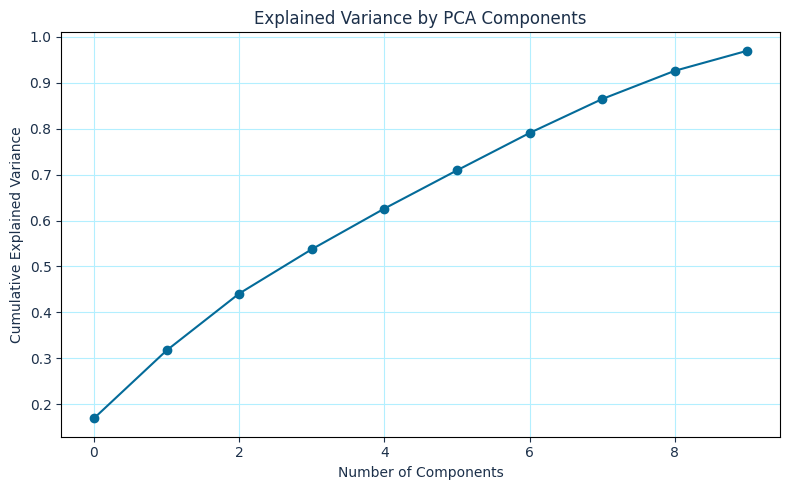

In [162]:
# Accessible color palette
palette = {
    "light": "#B3EFFF",
    "bright": "#00CFFF",
    "medium": "#046B99",
    "dark": "#1C304A"
}

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color=palette["medium"])
plt.xlabel('Number of Components', color=palette["dark"])
plt.ylabel('Cumulative Explained Variance', color=palette["dark"])
plt.title('Explained Variance by PCA Components', color=palette["dark"])
plt.grid(True, color=palette["light"])
plt.tick_params(colors=palette["dark"])
plt.tight_layout()
plt.show()


## 11. K-Means Clustering and Evaluation


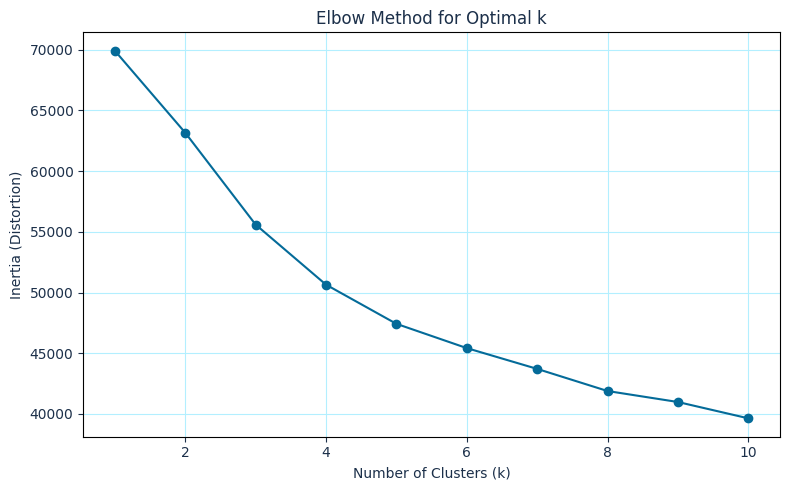

In [163]:
# Try different numbers of clusters and record inertia (distortion)
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Accessible color palette
palette = {
    "light": "#B3EFFF",
    "medium": "#046B99",
    "dark": "#1C304A"
}

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', color=palette["medium"])
plt.xlabel('Number of Clusters (k)', color=palette["dark"])
plt.ylabel('Inertia (Distortion)', color=palette["dark"])
plt.title('Elbow Method for Optimal k', color=palette["dark"])
plt.grid(True, color=palette["light"])
plt.tick_params(colors=palette["dark"])
plt.tight_layout()
plt.show()

In [165]:
# Silhouette scores help validate cluster separation
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(X_pca)
kmeans_4 = KMeans(n_clusters=4, random_state=42).fit(X_pca)

score_3 = silhouette_score(X_pca, kmeans_3.labels_)
score_4 = silhouette_score(X_pca, kmeans_4.labels_)

print(f"Silhouette Score for k=3: {score_3:.3f}")
print(f"Silhouette Score for k=4: {score_4:.3f}")


Silhouette Score for k=3: 0.165
Silhouette Score for k=4: 0.163


In [166]:
# Fit final KMeans model with chosen k (based on elbow + silhouette)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add clusters to PCA dataframe for plotting and analysis
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['cluster'] = clusters


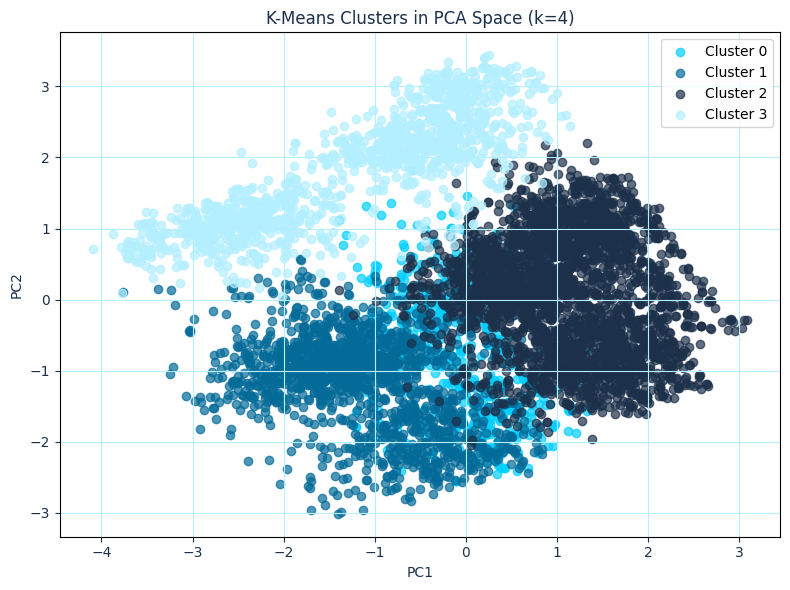

In [167]:
# Cluster-specific colors from accessible palette
cluster_colors = ['#00CFFF', '#046B99', '#1C304A', '#B3EFFF']

plt.figure(figsize=(8, 6))
for cluster_id in sorted(pca_df['cluster'].unique()):
    cluster_data = pca_df[pca_df['cluster'] == cluster_id]
    plt.scatter(
        cluster_data['PC1'], cluster_data['PC2'],
        label=f'Cluster {cluster_id}',
        color=cluster_colors[cluster_id % len(cluster_colors)],
        alpha=0.7
    )

plt.xlabel('PC1', color=palette["dark"])
plt.ylabel('PC2', color=palette["dark"])
plt.title('K-Means Clusters in PCA Space (k=4)', color=palette["dark"])
plt.grid(True, color=palette["light"])
plt.tick_params(colors=palette["dark"])
plt.legend()
plt.tight_layout()
plt.show()


## 12. Summary and Next Steps


All preprocessing and unsupervised learning steps are now complete. This includes:

- Dropping irrelevant or high-missingness columns
- Encoding categorical variables with custom functions
- Handling missing values using both median and model-based imputation
- Log-transforming the target variable to correct skew
- Scaling and standardizing features
- Reducing dimensionality with PCA
- Identifying natural groupings using K-Means clustering

These transformed datasets are now ready to be used for supervised modeling.

**Next Steps**:
- Train baseline and advanced regression models (e.g., Linear Regression, Random Forest, Neural Network)
- Evaluate performance using MAE, MSE, and R²
- Interpret feature importance and cluster contributions

## 13. Save Final Datasets

In [ ]:
# Save transformed data for modeling
X_train_scaled.to_csv('X_train_scaled.csv')
X_test_scaled.to_csv('X_test_scaled.csv')
y_train_log.to_csv('y_train_log.csv')
y_test_log.to_csv('y_test_log.csv')


## 14. Code Validation Note

> Code has been tested and runs without error in both Google Colab and local environments. All transformations have been validated at key checkpoints with print statements and visualizations.
